In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "/content/drive/My Drive/20_newsgroups.zip"
# !unzip -q "/content/newsgroups.zip"

In [0]:
pip install num2words

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
from collections import defaultdict
from collections import Counter
from num2words import num2words

import re
import os
import math
import nltk
import numpy as np
import heapq

**pre-process data**

In [0]:
import re

def pre_process(file):
  f = open(file,'r',encoding="ISO-8859-1")
  data = f.readlines()
  docs = []

  for sent in data:
    sent = re.sub(r'[\.•,;:?!#=+$%^&*_~><\-\(\)\{\}\[\]\"\'\|\/]','',sent)
    docs.append(sent.lower())
  return docs

**number to words**

In [0]:
def numberTowords(word):
  if(word.isnumeric()):
    return num2words(word)
  else:
    return word

**remove stop-words**

In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

def removeStop(tokens):
  stop = set(stopwords.words('english'))
  f_tokens = []
  
  for w in tokens:
    if w not in stop:
      f_tokens.append(w)
  
  return f_tokens

**generate tokens**

In [0]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lm = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def tokenise(docs):
  i = 0
  lem_words = []

  for k in docs:
    tokens = k.split()
    f_tokens = removeStop(tokens)

    for j in f_tokens:
      lem_words.append(lm.lemmatize(j))
    
  return lem_words

**remove metadata**

In [0]:
import re
def meta_data(path,f):
    output = []
    with open(os.path.join(path,f),"r+",encoding="ISO-8859-1") as fh:
        for line in fh:
            if not re.search("[\w]+:\s",line):
                output.append(line)
        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.writelines(output)
        fh.close()
        newoutput=[]
        fh=open(os.path.join(path,f),"r+",encoding="ISO-8859-1")
        for line in fh:
            if not re.search("(--)+|(==)+",line):
                newoutput.append(line)
            else:
                break

        fh.close()

        fh = open(os.path.join(path,f),"w")
        fh.seek(0)
        fh.truncate()
        fh.writelines(newoutput)
        fh.close()

**mapping documents**

In [0]:

directory = ["talk.politics.misc","comp.graphics","rec.sport.hockey","sci.med","sci.space"]
path = "/content/20_newsgroups/"

In [0]:
mapping = defaultdict(lambda:None)

count=0

for d in directory:
  flist = []
  d_path = path+d                   # path that will lead us inside the directory
  flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
  for i in flist:
    count = count+1
    mapping[d+'/'+i] = str(count) + "_" + d

print(len(mapping))

5000


**splitting data into train and test**

In [0]:
# We are going to split the data class-wise, i.e., some random documents as training set
# and some other random sample as testing set
# Reference :: https://stackoverflow.com/questions/17412439/how-to-split-data-into-trainset-and-testset-randomly

import random

train_data = []
test_data = []

def split_train_test(ratio):
  for d in directory:
    flist = []
    d_path = path+d                   # path that will lead us inside the directory
    flist = os.listdir(d_path)        # this will list all the files in the folder 'd'

    random.shuffle(flist)             #shuffling the files present in the class

    train = flist[:int((len(flist)+1)*(ratio/100))]         #Remaining 80% to training set
    test = flist[int(len(flist)*(ratio/100)):]

    for i in train:
      train_data.append(d+'/'+i)

    for i in test:    
      test_data.append(d+'/'+i)
    
  random.shuffle(train_data)
  random.shuffle(test_data)

In [0]:
split_train_test(80)

###TRAINING PART

**counting number of docs in each class**

In [0]:
file_count = defaultdict(lambda:0)

for item in train_data:
  d = item.split('/')[0]
  file_count[d] += 1

**Building tokens dictionaries**

In [0]:
def build_dictionaries(train_data):

  vocab = set()
  tokens_dict = defaultdict(list)                           #dictionary that stores tokens of each document
  doc_list = defaultdict(list)
  
  for d in directory:
    flist = []
    d_path = path+d                   # path that will lead us inside the directory
    flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
    
    for f in flist:
      i = d+'/'+f
      if i in train_data:
        doc_list[d].append(f)

        meta_data(d_path,f)
        pre_p = pre_process(d_path+'/'+f)
        lemmas = tokenise(pre_p)

        for term in lemmas:
          term = numberTowords(term)
          vocab.add(term)
          tokens_dict[i].append(term)

  return tokens_dict,vocab,doc_list


In [0]:

tokens_dict,vocab,docs = build_dictionaries(train_data)

In [0]:
def compute_n11():
  N11 = defaultdict(lambda:defaultdict(lambda:0))

  for d in directory:
    for f in docs[d]:
      for word in vocab:
        if word in tokens_dict[d+'/'+f]:            
          N11[d][word] += 1

  return N11

N11 = compute_n11()

**Building MI table**

In [0]:
mi = defaultdict(lambda:defaultdict(lambda:0.0))

def find_mi(word,label,n11,n01,n10,n00):
  n = n11 + n01 + n10 + n00

  t1 = math.log(( (n*n11)/((n11+n10)*(n01+n11)) ),2)
  t1 = (n11/n) * t1

  t2 = math.log(( (n*n01)/((n01+n00)*(n01+n11)) ),2)
  t2 = (n01/n) * t2

  t3 = math.log(( (n*n10)/((n11+n10)*(n10+n00)) ),2)
  t3 = (n10/n) * t3

  t4 = math.log(( (n*n00)/((n01+n00)*(n10+n00)) ),2)
  t4 = (n00/n) * t4

  mi[label][word] = t1 + t2 + t3 + t4

In [0]:
def build_mi_table():
  for d in directory:
    for word in vocab:
      n11 = N11[d][word]
      n01 = (file_count[d] - n11)

      n10 = 0
      f_count = 0
      for d1 in directory:
        if d1!=d:
          n10 += N11[d1][word]
          f_count += file_count[d1]

      n00 = f_count - n10

      find_mi(word,d,n11+1,n01+1,n10+1,n00+1)

In [0]:
build_mi_table()

In [0]:
for d in directory:
  print(len(mi[d]))

34477
34477
34477
34477
34477


**selecting features**

In [0]:
def reduce_feature(k):
  selected_features = defaultdict(list)

  for d in directory:
    toplist = heapq.nlargest(k, mi[d].items(), key=lambda x: x[1]) # x[1] because we want to sort according to 2nd value of the tuple

    for i in toplist:
      selected_features[d].append(i[0])

  return selected_features

In [0]:
k = 8000
selected_features = reduce_feature(k)

**Selected feature space**

In [0]:
def build_vocab():
  new_vocab = set()

  for d in directory:
    for i in selected_features[d]:
      new_vocab.add(i)
  
  return new_vocab

new_vocab = build_vocab()

Reduced tokens

In [0]:
def generate_tokens():
  class_tokens = defaultdict(list)

  for d in directory:
    for f in docs[d]:
      for word in tokens_dict[d+'/'+f]:
        if word in new_vocab:
          class_tokens[d].append(word)
    
  return class_tokens

class_tokens = generate_tokens()

###CLASSIFICATION of TEST DATA

###### NAIVE BAYES

Calculating probabilities

In [0]:
#used add-one smoothing
def store_prob():

  log_prob = defaultdict(lambda:defaultdict(lambda:0.0))

  for word in new_vocab:
    for d in directory:
      count_word = Counter(class_tokens[d])[word] + 1
      count_token = len(class_tokens[d]) + len(new_vocab)
      
      p_w = np.log((count_word*1.0/count_token))      
      log_prob[word][d] = p_w
    
  return log_prob

log_prob = store_prob()

 > **1. Naive Bayes**

**Plotting the results**

In [0]:
from sklearn.metrics import confusion_matrix

def heat_plot(y_true,y_pred,matrix):
  
  labels = ["rec.sport.hockey","sci.med","comp.graphics","sci.space","talk.politics.misc"]

  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(matrix,cmap = 'tab20c')
  fig.colorbar(cax)
  ax.set_fc('y')
  ax.set_xticklabels([''] + labels,rotation=30)
  ax.set_yticklabels([''] + labels)

  # Loop over data dimensions and create text annotations.
  for i in range(5):
      for j in range(5):
          text = ax.text(j, i, matrix[i, j],ha="center", va="center", color="w")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


**Predicting the test set**




In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def predict_class_NB(test_data):
  p_c = np.log((1/5))                       # because each class is equally likely
  correct = 0
  y_true=[]
  y_pred=[]

  print("Split ratio of the data set = 80:20")
  for item in test_data:
    
    output_prob = []

    d = mapping[item].split('_')[1]          # fetching the directory name from the mapping dict
    label = d
    # print("True Label =",label)

    d_path = path + d                        # path that will lead us inside the directory
    f = item.split('/')[1]                   # fetching file name from the item in train_data
    
    meta_data(d_path,f)
    pre_p = pre_process(d_path+'/'+f)
    lemmas = tokenise(pre_p)

    for d in directory:
      prob = 0
      for term in lemmas:
        term = numberTowords(term)

        if(term in new_vocab):
          prob += log_prob[term][d]
        else:
          prob += np.log(1.0/(len(class_tokens[d]) + len(new_vocab)))
      prob += p_c
      output_prob.append((prob,d))

    #print(output_prob)
    predicted = max(output_prob)[1]

    # print("predicted =", predicted)

    if(predicted == label):
      correct +=1
    y_true.append(label)
    y_pred.append(predicted)

  print("Number of features selected using MI technique = ",k)
  print("\nTotal number of documents tested =",len(test_data))
  print("Number of documents correctly predicted =",correct)
  
  print("Accuracy = ", correct/len(test_data)*100)
  c = confusion_matrix(y_true, y_pred, labels=directory)
  print("\nConfusion matrix::\n",c)
  print()
  heat_plot(y_true,y_pred,c)


Split ratio of the data set = 80:20
Number of features selected using MI technique =  8000

Total number of documents tested = 1000
Number of documents correctly predicted = 919
Accuracy =  91.9

Confusion matrix::
 [[195   1   0   2   2]
 [  4 188   1   2   5]
 [ 12   3 184   0   1]
 [ 14   4   2 173   7]
 [  8  10   0   3 179]]



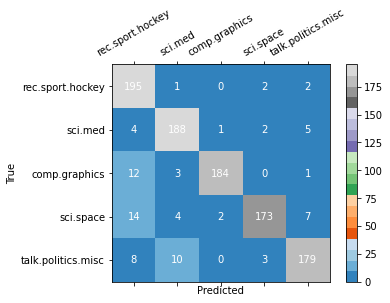

In [0]:
predict_class_NB(test_data)

######K-NN

> **2. K-Nearest Neighbour**

**computing tf**

In [0]:
def build_tf(train_data):
  tf = defaultdict(lambda:defaultdict(lambda:0))
  doc_list = defaultdict(list)

  for d in directory:
    # print(d)
    flist = []
    d_path = path+d                   # path that will lead us inside the directory
    flist = os.listdir(d_path)        # this will list all the files in the folder 'd'    
    
    for f in flist:
      i = d+'/'+f
      # print(i)
      if i in train_data:
        doc_list[d].append(f)
        sf = selected_features[d]

        meta_data(d_path,f)
        pre_p = pre_process(d_path+'/'+f)
        lemmas = tokenise(pre_p)

        for term in lemmas:
          term = numberTowords(term)

          if term in sf:
            tf[i][term] +=1

  return tf,doc_list

In [0]:
tf_dict,docs = build_tf(train_data)

**Generate Document vector**

In [0]:
def document_vector(file):
  tf_values = tf_dict[file]
  d_vector = np.zeros(len(new_vocab))
  
  for pos,w in enumerate(new_vocab):
    d_vector[pos] = tf_values[w]
  
  return d_vector


**Generate test vector**

In [0]:
def test_vector(file_path):
  test_tf = defaultdict(lambda:0)

  pre_p = pre_process(file_path)
  lemmas = tokenise(pre_p)

  for w in lemmas:
    w = numberTowords(w)
    test_tf[w] +=1
  
  t_vector = np.zeros(len(new_vocab))

  for pos,w in enumerate(new_vocab):
    t_vector[pos] = test_tf[w]

  return t_vector

**Compute euclidean distance**

In [0]:
def compute_euclidean(t_vector,d_vector):
  diff = t_vector - d_vector
  diff = diff * diff

  dist = np.sqrt(np.sum(diff))

  return dist

**Classifying the test data**

In [0]:
def knn(k,result):
  prediction = []

  res = heapq.nsmallest(k, result, key=lambda x: x[0])
  
  for i in res:
    predicted = i[1].split('/')[0]
    prediction.append(predicted)
    
  return prediction

In [0]:
def predict_class_knn(test_data):
  
  print("\nRESULTS OF K-NN FOR k =",5,"\n")
  correct = 0
  y_true = []
  y_pred = []
  n=3
  print("Split ratio of the data set = 80:20")

  for item in test_data:

    d = item.split('/')[0]                   # fetching the directory name from the mapping dict
    f = item.split('/')[1]                   # fetching file name from the item in train_data

    label = d
    y_true.append(label)
    # print("\nTrue Label =",label)

    d_path = path + d                        # path that will lead us inside the directory

    t_vector = test_vector(d_path+'/'+f)            # generate test vector
    output_dist = []
    
    for d in directory:
      for f in docs[d]:
        d_vector = document_vector(d+'/'+f)

        dist = compute_euclidean(t_vector,d_vector)
        output_dist.append((dist,d+'/'+f))

    result = knn(n,output_dist)
    predicted = max(set(result), key = result.count)          #finds the class that occurs max times
    y_pred.append(predicted)
    # print("Predicted Label = ",predicted)

    if(predicted==label):
      correct+=1

  print("Number of features selected using MI technique = ",k)
  print("\nTotal number of documents tested =",len(test_data))
  print("Number of documents correctly predicted =",correct)
  
  print("Accuracy = ", correct/len(test_data)*100)
  c = confusion_matrix(y_true, y_pred, labels=directory)
  print("\nConfusion matrix::\n",c)
  print()
  heat_plot(y_true,y_pred,c)

In [0]:
small = ['comp.graphics/39048', 'talk.politics.misc/178774', 'talk.politics.misc/176996', 'rec.sport.hockey/53867']

predict_class_knn(small)

In [0]:
predict_class_knn(test_data)